### Privacy preserving logistic regression
#### Unweighted, discrete

There are three main methods to compute a differentially private, unweighted, discrete logistic regression.
1. reframe discrete predictors as a table of values, add laplace noise
2. randomized response
3. perturbed optimization

In this notebook, we will explore each method and evaluate their privacy/accuracy tradeoff performance.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests, zipfile, io
import sklearn
import random
from typing import Union
import statsmodels.api as sm

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Base Logistic Regression

In [2]:
r = requests.get('https://www2.census.gov/programs-surveys/acs/data/pums/2017/5-Year/csv_ppa.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extract('psam_p42.csv')
pa = pd.read_csv("psam_p42.csv")

In [4]:
#getting data
new_pa = pa.query('PUMA==1300 and AGEP>=18 and AGEP<=65').filter(items=['PUMA','RAC1P','PINCP','AGEP','SCHL'])
new_pa.head()
#TODO clean data

,PUMA,RAC1P,PINCP,AGEP,SCHL
436,1300,1,65000.0,56,22.0
437,1300,1,15000.0,54,20.0
590,1300,1,62000.0,57,16.0
591,1300,1,44500.0,58,16.0
652,1300,1,20000.0,46,15.0


In [5]:
def labeler (income):
    median = new_pa['PINCP'].median()
    if income > median:
        return 1
    elif income < median:
        return 0
    else:
        return random.randint(0,1)

In [6]:
#feature selection 
#TODO: change Y value to rent or mortage
X = new_pa[['RAC1P','AGEP','SCHL']]
y = new_pa['PINCP'].apply(labeler)

In [7]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.681380
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.017     
Dependent Variable: PINCP            AIC:              12029.6338
Date:               2019-08-06 13:43 BIC:              12050.8891
No. Observations:   8823             Log-Likelihood:   -6011.8   
Df Model:           2                LL-Null:          -6115.6   
Df Residuals:       8820             LLR p-value:      8.7378e-46
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
RAC1P     -0.3625     0.0390   -9.3002   0.0000   -0.4389   -0.2861
AGEP       0.0086     0.0014    6.2559   0.0000    0.0059 

## Laplace Noise

In [8]:
def laplace_mech(mu: Union[float, np.ndarray], epsilon: int, sensitivity: float = 1.0):
    """
    Implementation of the Laplace Mechanism

    Args:
      mu (float or numpy array): the true answer
      epsilon (int): the privacy budget
      sensitivity (float): the global sensitivity of the query
    """
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z

In [12]:
def avg_l1_laplace(epsilon, mu, n=1000):
    """Takes the average error of the laplace mechanism on an array over n samples.
  　
    Args:
      epsilon (int): the privacy budget
      mu (float or numpy array): the true answer
      n (int): number of samples
    """
    total = 0
    for i in range(n):
        noisy_arr = laplace_mech(mu, epsilon, sensitivity=1.0)
        accuracy = 1 - (np.linalg.norm(noisy_arr-mu, 1)/(2*noisy_arr.shape[1]))
        total += accuracy
    return total/n


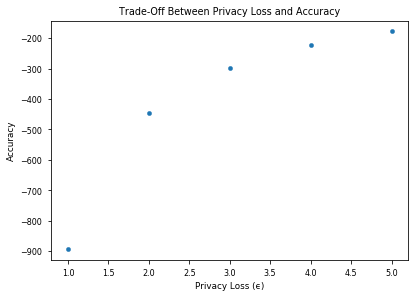

In [13]:
orig_arr = pd.DataFrame(new_pa.fillna(0))
accuracy_df = pd.DataFrame()
eps_range = np.arange(1,6.0,1)
accuracy_df['Privacy Loss (ϵ)'] = eps_range
accuracy_df['Accuracy'] = [avg_l1_laplace(x, orig_arr) for x in eps_range]
accuracy_df.plot.scatter('Privacy Loss (ϵ)', 'Accuracy')
plt.title('Trade-Off Between Privacy Loss and Accuracy')
plt.style.use('seaborn-paper')
plt.savefig('out/fig.png',facecolor='w', edgecolor='w',
        orientation='portrait', ransparent=False, bbox_inches=None, pad_inches=0.1)
plt.show()

In [11]:
noisy_microdata = laplace_mech(orig_arr,3)
X = noisy_microdata[['RAC1P','AGEP','SCHL']]
y = noisy_microdata['PINCP'].apply(labeler)
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.684137
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.013     
Dependent Variable: PINCP            AIC:              12078.2729
Date:               2019-08-06 13:43 BIC:              12099.5283
No. Observations:   8823             Log-Likelihood:   -6036.1   
Df Model:           2                LL-Null:          -6115.5   
Df Residuals:       8820             LLR p-value:      3.3688e-35
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
RAC1P     -0.2252     0.0240   -9.3906   0.0000   -0.2723   -0.1782
AGEP       0.0081     0.0014    5.9043   0.0000    0.0054 

## Random Response 